In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sei.graphics.plot as plot

<br>

1. Cutoff de 100 000
2. Avec un knot de 2 ca fait n'imp
3. Une taille minim de 1e6 semble nécessaire (400 000 SNPs environ) dans le cas de la croissance

<br>

# SFS visualisation

In [2]:
cst = pd.read_json('./Data/SMC/optimization_smc/data/vcf_cst.zip')
growth = pd.read_json('./Data/SMC/optimization_smc/data/vcf_growth.zip')
# decline = pd.read_json('./Data/SMC/optimization_smc/data/vcf_decline.zip')

In [3]:
def plot_sfs(data, model):
    # Set up plot
    plt.figure(figsize=(12, 9), constrained_layout=True)
    
    for i, row in data.iterrows():
        # Color
        color = (0., 0. + (i/10), 1., 0.5)
        
        # Plot SFS
        #plt.plot(normalization(values['SFS']), label=species, color=color[values['Status']])
        with plt.style.context('seaborn-whitegrid'):  # use seaborn style for plot
            plt.plot(plot.normalization(row['SFS observed']), label="SFS - length={:.1e}".format(row['Parameters']['length']),
                     color=color, linestyle="dashed")

    # Plot theoritical SFS of any constant population
    theoretical_sfs = plot.compute_theoretical_sfs(len(row['SFS observed']))
    with plt.style.context('seaborn-whitegrid'):  # use seaborn style for plot
        plt.plot(plot.normalization(theoretical_sfs), label="Theoretical model - Fu, 1995", marker="o", color="tab:orange")

    # Label, caption & title
    plot.sfs_label(length=len(row['SFS observed']), title="SFS for SMC optimization - {} model".format(model))

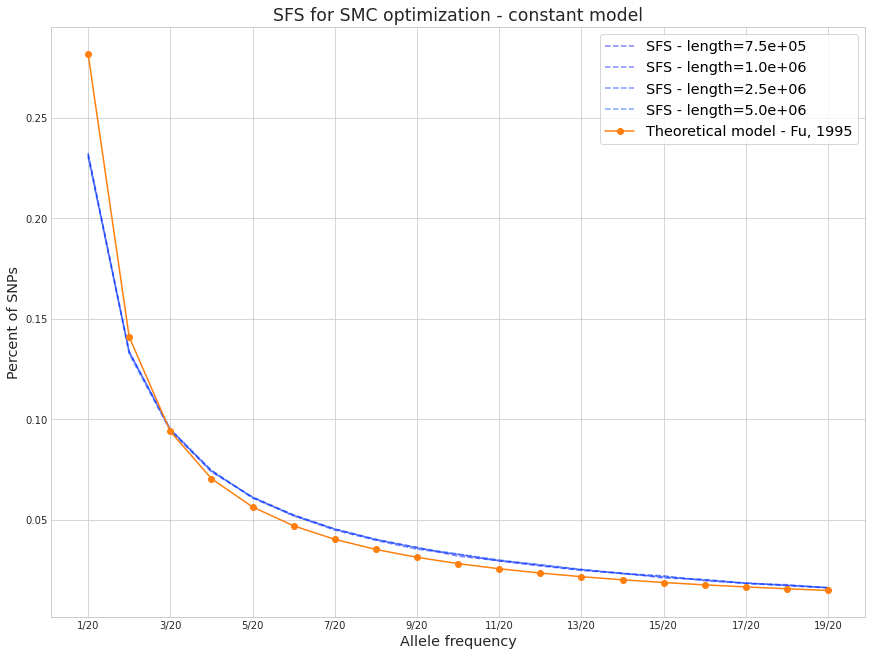

In [4]:
plot_sfs(cst[['Parameters', 'SFS observed']], model="constant")

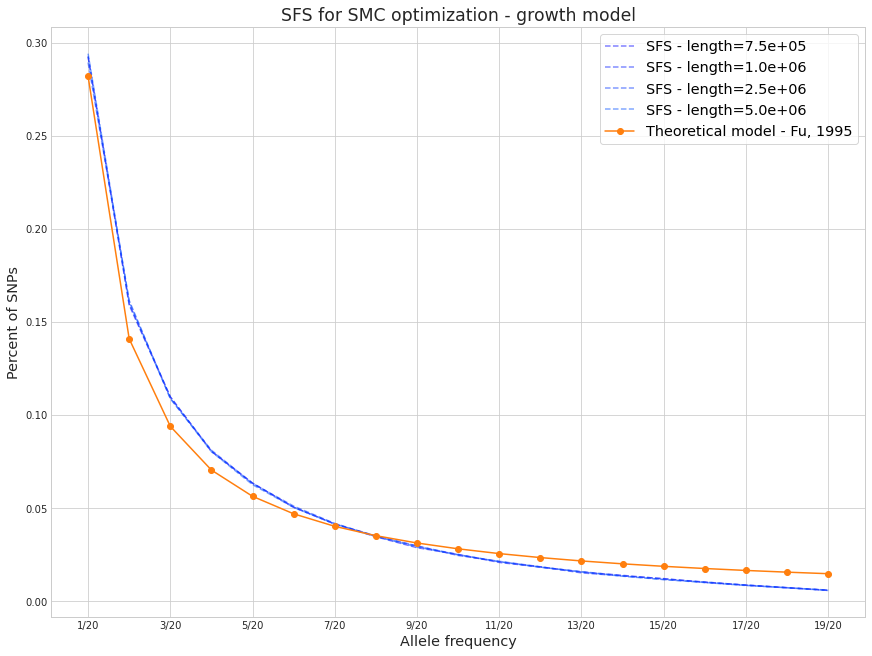

In [5]:
plot_sfs(growth[['Parameters', 'SFS observed']], model="growth")

<br>

In [56]:
def lrt_test(ll_m0, ll_m1):
    lrt = 2 * (ll_m1 - ll_m0)
    if lrt < 5.99:
        return 0, lrt
    return 1, lrt

def read_file(model):
    print("MODEL: {}".format(model))
    for knot in [2, 4, 6]:
        print("\n### KNOT={} ###\n".format(knot))
        path_data = "./Data/SMC/decline/{}-KNOTS={}/".format(model, knot)
        
        iter0 = pd.read_json("{}.model.iter0.json".format(path_data)).iloc[0]
        final = pd.read_json("{}model.final.json".format(path_data)).iloc[0]

        print("LL0: {}".format(iter0['LL']))
        print("LL1: {}".format(final['LL']))
        
        lrt = lrt_test(iter0['LL'], final['LL'])
        print(lrt)
        print("\nOVER\n")

In [53]:
read_file(model='cst')

MODEL: cst

### KNOT=2 ###

LL0: -11.957702640918427
LL1: -4.445959755506603
(1, 15.023485770823648)

OVER


### KNOT=4 ###

LL0: -11.719297591065253
LL1: -9.016881758572268
(0, 5.40483166498597)

OVER


### KNOT=6 ###

LL0: -2030.037587854479
LL1: -8.27690808858118
(1, 4043.5213595317955)

OVER



In [54]:
read_file(model='decline')

MODEL: decline

### KNOT=2 ###

LL0: -3337.1374557097406
LL1: -10.32110496517463
(1, 6653.632701489132)

OVER


### KNOT=4 ###

LL0: -11.47583249225299
LL1: -7.992399625151071
(1, 6.966865734203839)

OVER


### KNOT=6 ###

LL0: -11.644444393637047
LL1: -8.682794130387926
(0, 5.923300526498242)

OVER



In [55]:
read_file(model='growth')

MODEL: growth

### KNOT=2 ###

LL0: -1924.744066866437
LL1: -3.920484240490212
(1, 3841.6471652518935)

OVER


### KNOT=4 ###

LL0: -10.60269240546504
LL1: -3.807423362758416
(1, 13.590538085413248)

OVER


### KNOT=6 ###

LL0: -9.659815429339995
LL1: -3.611699207708825
(1, 12.09623244326234)

OVER



In [169]:
def lrt_test(ll_m0, ll_m1):
    lrt = 2 * (ll_m1 - ll_m0)
    if lrt < 5.99:
        return 0, lrt
    return 1, lrt

def read_file(model):
    print("MODEL: {}".format(model))
    for length in [1e4, 2.5e4, 5e4, 7.5e4, 1e5, 2.5e5, 5e5, 7.5e5, 1e6, 2.5e6, 5e6, 7.5e6]:
        print("\n### LENGTH={:.1e} ###\n".format(length))
        
        for knot in range(2, 9):
            print('KNOT={} => '.format(knot), end="")
            path_data = "./Data/SMC/optimization_smc/{}/.length={:.1e}-KNOTS={}/".format(model, length, knot)

            with open("{}.debug.txt".format(path_data), 'r') as filin:
                lines = filin.readlines()
                tmp = []
                for line in lines:
                    s = line.strip().split(' ')
                    if len(s) > 1 and s[1] == "smcpp.optimize.plugins.loglikelihood_monitor":
                        tmp.append(s)

            if tmp and len(tmp) > 1:
                l0 = float(tmp[0][4])
                l1 = float(tmp[-2][5].split('\t')[0])
                lrt = lrt_test(l0, l1)
            
                if lrt[0] == 0:
                    print("NON rejet de H0 (avec l0={} & l1={})".format(round(l0, 2), round(l1, 2)))
                else:
                     print("REJET de H0 (avec l0={} & l1={})".format(round(l0, 2), round(l1, 2)))   

            else:
                print('no data')

        print("\nOVER\n")

In [170]:
read_file(model='cst')

MODEL: cst

### LENGTH=1.0e+04 ###

KNOT=2 => REJET de H0 (avec l0=-21027.69 & l1=-11.03)
KNOT=3 => REJET de H0 (avec l0=-21027.69 & l1=-16.66)
KNOT=4 => REJET de H0 (avec l0=-21027.69 & l1=-16.05)
KNOT=5 => REJET de H0 (avec l0=-21027.69 & l1=-15.64)
KNOT=6 => REJET de H0 (avec l0=-21027.69 & l1=-15.33)
KNOT=7 => REJET de H0 (avec l0=-21027.69 & l1=-15.08)
KNOT=8 => no data

OVER


### LENGTH=2.5e+04 ###

KNOT=2 => REJET de H0 (avec l0=-51651.12 & l1=-53.17)
KNOT=3 => REJET de H0 (avec l0=-51651.12 & l1=-104.39)
KNOT=4 => REJET de H0 (avec l0=-51651.12 & l1=-97.67)
KNOT=5 => REJET de H0 (avec l0=-51651.12 & l1=-93.46)
KNOT=6 => REJET de H0 (avec l0=-51651.12 & l1=-90.33)
KNOT=7 => REJET de H0 (avec l0=-51651.12 & l1=-87.86)
KNOT=8 => no data

OVER


### LENGTH=5.0e+04 ###

KNOT=2 => REJET de H0 (avec l0=-106473.03 & l1=-102.69)
KNOT=3 => REJET de H0 (avec l0=-106473.03 & l1=-150.56)
KNOT=4 => REJET de H0 (avec l0=-106473.03 & l1=-143.59)
KNOT=5 => REJET de H0 (avec l0=-106473.03 & l1=

In [163]:
read_file(model='growth')

MODEL: growth

### LENGTH=1.0e+04 ###

KNOT=2 => REJET de H0 (avec l0=-17878.08 & l1=-35.8)
KNOT=3 => REJET de H0 (avec l0=-17878.03 & l1=-35.77)
KNOT=4 => REJET de H0 (avec l0=-17878.08 & l1=-35.58)
KNOT=5 => REJET de H0 (avec l0=-17877.99 & l1=-35.35)
KNOT=6 => REJET de H0 (avec l0=-17877.98 & l1=-35.17)
KNOT=7 => no data
KNOT=8 => no data

OVER


### LENGTH=2.5e+04 ###

KNOT=2 => REJET de H0 (avec l0=-45772.9 & l1=-60.13)
KNOT=3 => REJET de H0 (avec l0=-45772.74 & l1=-60.09)
KNOT=4 => REJET de H0 (avec l0=-45772.66 & l1=-60.06)
KNOT=5 => REJET de H0 (avec l0=-45772.64 & l1=-60.03)
KNOT=6 => REJET de H0 (avec l0=-45772.63 & l1=-60.01)
KNOT=7 => no data
KNOT=8 => no data

OVER


### LENGTH=5.0e+04 ###

KNOT=2 => REJET de H0 (avec l0=-92178.13 & l1=-140.82)
KNOT=3 => REJET de H0 (avec l0=-92177.83 & l1=-137.48)
KNOT=4 => REJET de H0 (avec l0=-92177.65 & l1=-136.22)
KNOT=5 => REJET de H0 (avec l0=-92177.62 & l1=-134.69)
KNOT=6 => REJET de H0 (avec l0=-92177.59 & l1=-134.2)
KNOT=7 => REJ

In [171]:
read_file(model='decline')

MODEL: decline

### LENGTH=1.0e+04 ###

KNOT=2 => REJET de H0 (avec l0=-28194.17 & l1=-49.48)
KNOT=3 => REJET de H0 (avec l0=-28194.17 & l1=-44.82)
KNOT=4 => REJET de H0 (avec l0=-28194.17 & l1=-42.59)
KNOT=5 => REJET de H0 (avec l0=-28194.17 & l1=-41.17)
KNOT=6 => REJET de H0 (avec l0=-28194.17 & l1=-40.13)
KNOT=7 => REJET de H0 (avec l0=-28194.17 & l1=-38.74)
KNOT=8 => REJET de H0 (avec l0=-28194.17 & l1=-201.49)

OVER


### LENGTH=2.5e+04 ###

KNOT=2 => REJET de H0 (avec l0=-68944.67 & l1=-109.46)
KNOT=3 => REJET de H0 (avec l0=-68944.67 & l1=-99.54)
KNOT=4 => REJET de H0 (avec l0=-68944.67 & l1=-94.39)
KNOT=5 => REJET de H0 (avec l0=-68944.67 & l1=-90.78)
KNOT=6 => REJET de H0 (avec l0=-68944.67 & l1=-87.79)
KNOT=7 => REJET de H0 (avec l0=-68944.67 & l1=-83.46)
KNOT=8 => REJET de H0 (avec l0=-68944.67 & l1=-546.45)

OVER


### LENGTH=5.0e+04 ###

KNOT=2 => REJET de H0 (avec l0=-139469.74 & l1=-188.84)
KNOT=3 => REJET de H0 (avec l0=-139469.74 & l1=-171.22)
KNOT=4 => REJET de H0 (av

IndexError: list index out of range